In [35]:
import os
from os import listdir, path
import time
import shutil
import numpy as np 
import pandas as pd
from tqdm import tqdm
import random
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
import seaborn as sns

import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision.transforms.transforms import Compose, Resize, ToTensor, CenterCrop, Normalize
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR

%matplotlib inline

if_gpu = torch.cuda.is_available()
print("GPU is on?", if_gpu)

4.1.1
GPU is on? False


In [2]:
# Global variables
SOURCE_DIR = '../../GDrive/Datasets/PlantSeedlings'
STD_IMGSIZE = 64

In [3]:
def show_sample_images(root_dir='..\Datasets\PlantSeedlings',sample_size=16,from_class=None):
    '''
    Display sample images from input directory
    '''
    # number of images on the x and y axes should be relatively close
    for i in range(int(sample_size**0.5 + 1), 0, -1):
        if sample_size % i == 0:
            N_images_x = i
            N_images_y = int(sample_size/N_images_x)
            break
 
    # sample data directory and show image in subplots
    fig, ax = plt.subplots(N_images_x, N_images_y, squeeze=False)
    for sample_number in range(sample_size):
        if not from_class:
            labels_list = listdir(path.join(root_dir, 'train'))
            label = str(random.sample(labels_list, 1)[0])
        
        parent_directory = path.join(root_dir, 'train', label)
        file_list = listdir(parent_directory)
        file_name = random.sample(file_list, 1)[0]
        img = Image.open(path.join(parent_directory, file_name))
        ax[sample_number % N_images_x][sample_number // N_images_x].imshow(img)
        ax[sample_number % N_images_x][sample_number // N_images_x].title.set_text(label)
        
    fig.set_figheight(N_images_y * 4)
    fig.set_figwidth(N_images_y * 4)
    #fig.show()  

In [3]:
def showcase_class(clf_data,class_id,n_samples):
    df = clf_data['Data']
    TruePos = (df.Class==class_id) & (df.PredictedClass==class_id)
    FalsePos = (df.Class!=class_id) & (df.PredictedClass==class_id)
    FalseNeg = (df.Class==class_id) & (df.PredictedClass!=class_id)
    
    
    

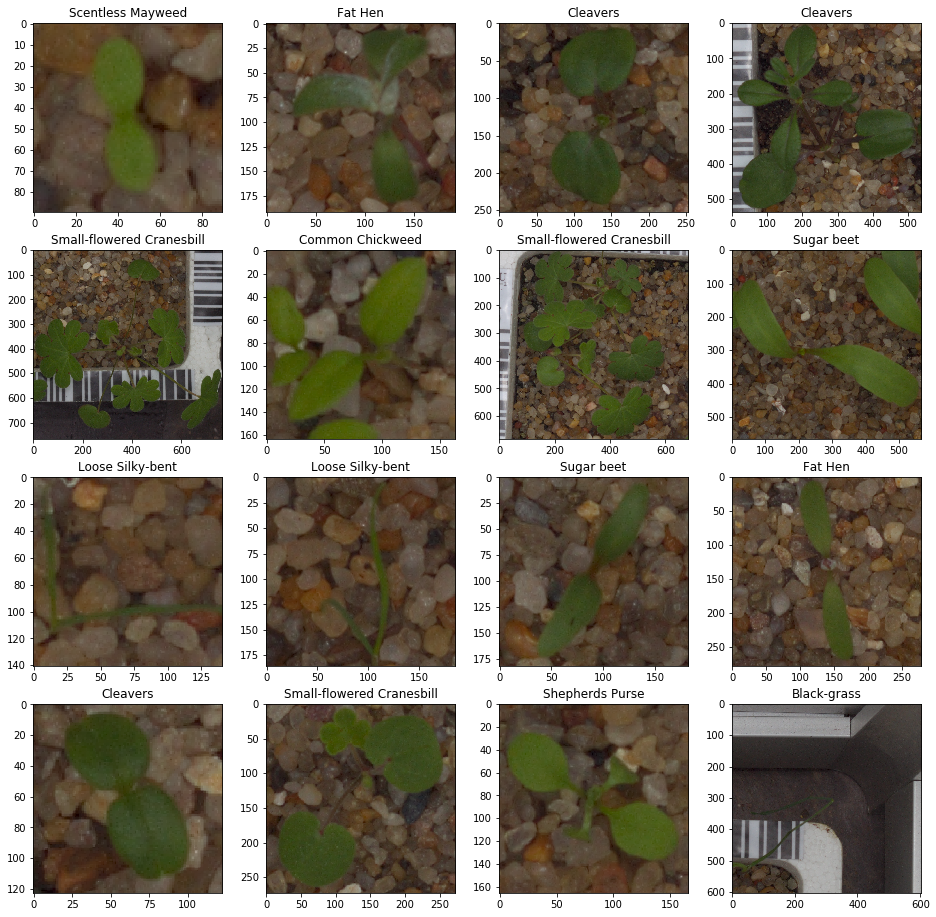

In [4]:
show_sample_images(SOURCE_DIR)
#os.listdir(path.join(SOURCE_DIR,'train'))

In [5]:
# Load all file names and classes in a DataFrame
def getImageList(root_dir):
    odf = pd.DataFrame(columns=['FileName','Class'])
    seedlingTypes = os.listdir(path.join(root_dir,'train'))
    for sType in seedlingTypes:
        ixClass = seedlingTypes.index(sType)
        fPath = path.join(root_dir, 'train', sType)
        file_list = os.listdir(fPath)
        tdf = pd.DataFrame(file_list,columns=['FileName'])
        tdf['Class'] = ixClass
        odf = odf.append(tdf)
    return(odf)

# Gets a balanced image list
def getBalancedList(source_df,test_size=0.15):
    capSize = source_df['Class'].value_counts().min()
    ClassList = source_df.Class.unique()
    odf = pd.DataFrame(columns=['FileName','Class'])
    for sType in ClassList:
        tdf = source_df[source_df['Class']==sType]
        odf = odf.append(tdf.sample(capSize))
    y = odf['Class']
    return(train_test_split(odf,test_size=test_size,stratify=y))

In [6]:
class SeedlingDataset(Dataset):
    def __init__(self,image_df,root_dir,transform=None):
        self.data = image_df
        self.root_dir = root_dir
        self.transform = transform
        self.seedlingTypes = os.listdir(path.join(root_dir,'train'))
        
    def __len__(self):
        return(len(self.data))
    
    def __getitem__(self,idx):
        imgFileName, imgLabel = self.data.iloc[idx]
        dirForLabel = self.seedlingTypes[imgLabel]
        img = Image.open(path.join(self.root_dir,'train', dirForLabel, imgFileName))
        img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        img = torch.from_numpy(np.array(img))
        label = torch.tensor(imgLabel)    
        return img, label
    
    def getClassNames(self):
        return self.seedlingTypes

In [7]:
def getDataLoaders(root_dir,batch_size,transforms,test_ratio=0.25):
    X_train, X_test  = getBalancedList(getImageList(root_dir),test_ratio)
    trainData = SeedlingDataset(X_train,root_dir,transforms)
    testData = SeedlingDataset(X_test,root_dir,transforms)
    trainLoader = DataLoader(trainData,batch_size=batch_size)
    testLoader = DataLoader(testData,batch_size=batch_size)
    return trainLoader, testLoader

In [8]:
class TinyModel(nn.Module):
    
    def __init__(self):
        super(TinyModel, self).__init__()
        self.bn1 = nn.BatchNorm2d(3)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(5, 5))
        self.bn2 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(in_channels=10 , out_channels=10, kernel_size=(5, 5), stride=2)
        self.fc1 = nn.Linear(7840, 128)
        self.fc2 = nn.Linear(128, 12)
        
    def forward(self, x):
        x = F.relu(self.conv1(self.bn1(x)))
        x = F.relu(self.conv2(self.bn2(x)))
        x = x.view(-1, 7840)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)
    
    def loss(self, prediction, true_values):

        return F.nll_loss(prediction, true_values)

In [77]:
def train(model, device, train_dataloader, optimizer, epoch, verbose=False):
    model.train()
    total_loss = 0
    for batch_idx, (image, label) in enumerate(train_dataloader):
        input_var = image.to(device)
        target_var = label.to(device)
        optimizer.zero_grad()
        output = model(input_var)
        loss = model.loss(output, target_var)
        loss.backward()
        optimizer.step()
        total_loss += loss
        if batch_idx % 10 == 0 and verbose:
            print('Train Epoch: {0}, Train batch: {1}, Batch loss: {2}'
                  .format(epoch, batch_idx, loss))
    
    epoch_loss = total_loss/(batch_idx + 1)
    return epoch_loss

def EvalModel(model, device, fortesting_dataloader):
    model.eval()
    evalStats = {}
    correct = 0
    preds = np.empty((0,1), int)
    with torch.no_grad():
        for image, label in fortesting_dataloader:
            input_var = image.to(device)
            target_var = label.to(device)
            output = model(input_var)
            prediction = output.argmax(dim=1, keepdim=True)
            correct += prediction.eq(target_var.view_as(prediction)).sum().item()
            preds = np.append(preds,prediction.numpy(),axis=0)
            
    evalStats['Accuracy'] = correct / len(fortesting_dataloader.dataset)
    evalStats['Predictions'] = preds.astype(int)
    return evalStats
            
def test(model, device, test_dataloader):
    eStats = EvalModel(model, device, test_dataloader)
    return eStats['Accuracy']

def getClassificationData(model,device,a_dataloader):
    cData = {}
    eStats = EvalModel(model, device, a_dataloader)
    df = a_dataloader.dataset.data.copy();
    labelList = a_dataloader.dataset.getClassNames()
    df['Class'] = df.Class.values.astype(int)
    df['PredictedClass'] = eStats['Predictions']
    cData['SourceDirectory'] = a_dataloader.dataset.root_dir
    cData['ClassNames'] = labelList
    cData['Data'] = df
    cData['CM'] = pd.DataFrame(confusion_matrix(df.Class.values, df.PredictedClass.values),
             columns=["P_" + class_name for class_name in labelList],
             index = [class_name for class_name in labelList])
    return cData

def printClassificationReport(cData):
    print(classification_report(cData['Data'].Class.values, cData['Data'].PredictedClass.values,target_names=cData['ClassNames']))

In [76]:
# main
losses = []
accuracies = []
n_epochs = 20
learning_rate = 0.1
lr_decay = 5 # every 10 epochs, the learning rate is divided by 10
batch_size = 24
use_cuda = False # use True to switch to GPU

device = torch.device("cuda" if use_cuda else "cpu")
model = TinyModel().to(device)
print('The model has {0} parameters'.format(sum([len(i.reshape(-1)) for i in model.parameters()]) ))

data_transformers = Compose([Resize(STD_IMGSIZE), CenterCrop(STD_IMGSIZE), ToTensor()])
train_loader, test_loader = getDataLoaders(SOURCE_DIR, batch_size, data_transformers, test_ratio=0.1)
print('Number of train examples: {0}, number of test examles: {1}'
      .format(len(train_loader.dataset), len(test_loader.dataset)))

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
lr_scheduler = StepLR(optimizer, step_size=1, gamma=0.70)

for epoch in range(1, n_epochs + 1):
    tic = time.time()
    epoch_loss = train(model, device, train_loader, optimizer, epoch)
    print('Training loss for epoch {0} is {1:.5f}.   LR={2}'.format(epoch, epoch_loss,lr_scheduler.get_lr()))
    losses.append(epoch_loss)
    accuracy = test(model, device, test_loader)
    print('Test accuracy: {0:.3f}'.format(accuracy))
    accuracies.append(accuracy)
    lr_scheduler.step()
    tac = time.time()
    print('Epoch time: {0:0.1f} seconds'.format(tac - tic))

The model has 1008492 parameters
Number of train examples: 2386, number of test examles: 266
Training loss for epoch 1 is 2.23352.   LR=[0.1]
Test accuracy: 0.241
Epoch time: 49.5 seconds
Training loss for epoch 2 is 1.58759.   LR=[0.048999999999999995]
Test accuracy: 0.380
Epoch time: 47.4 seconds
Training loss for epoch 3 is 1.04959.   LR=[0.0343]
Test accuracy: 0.444
Epoch time: 47.4 seconds
Training loss for epoch 4 is 0.64644.   LR=[0.024009999999999997]
Test accuracy: 0.620
Epoch time: 48.1 seconds
Training loss for epoch 5 is 0.37695.   LR=[0.016806999999999996]
Test accuracy: 0.628
Epoch time: 48.0 seconds
Training loss for epoch 6 is 0.19707.   LR=[0.011764899999999997]
Test accuracy: 0.643
Epoch time: 48.5 seconds
Training loss for epoch 7 is 0.10044.   LR=[0.008235429999999997]
Test accuracy: 0.647
Epoch time: 48.1 seconds
Training loss for epoch 8 is 0.06047.   LR=[0.005764800999999997]
Test accuracy: 0.654
Epoch time: 47.8 seconds
Training loss for epoch 9 is 0.04324.   LR

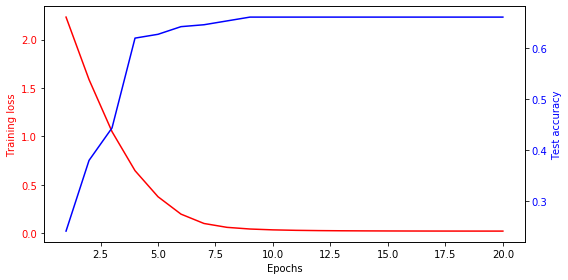

In [78]:
fig, ax1 = plt.subplots(figsize=(8,4))

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss', color='r')
ax1.plot(range(1, n_epochs + 1), losses, color='r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.set_ylabel('Test accuracy', color='b')
ax2.plot(range(1, n_epochs + 1), accuracies, color='b')
ax2.tick_params(axis='y', labelcolor='b')
fig.tight_layout()
plt.show()

In [79]:
testData = getClassificationData(model, device, test_loader)

In [80]:
testData['Data'].head()

,FileName,Class,PredictedClass
262,fef14b865.png,0,0
230,ffb54800c.png,9,8
334,9ab3b61db.png,8,11
63,1a570b7db.png,8,7
136,907817b91.png,7,11


In [81]:
printClassificationReport(testData)

                           precision    recall  f1-score   support

              Black-grass       0.56      0.45      0.50        22
                 Charlock       0.95      0.87      0.91        23
                 Cleavers       0.82      0.82      0.82        22
         Common Chickweed       0.89      0.77      0.83        22
             Common wheat       0.63      0.52      0.57        23
                  Fat Hen       0.64      0.64      0.64        22
         Loose Silky-bent       0.39      0.50      0.44        22
                    Maize       0.64      0.73      0.68        22
        Scentless Mayweed       0.41      0.50      0.45        22
          Shepherds Purse       0.56      0.45      0.50        22
Small-flowered Cranesbill       0.84      0.95      0.89        22
               Sugar beet       0.73      0.73      0.73        22

                 accuracy                           0.66       266
                macro avg       0.67      0.66      0.66    

In [82]:
testData['CM']

,P_Black-grass,P_Charlock,P_Cleavers,P_Common Chickweed,P_Common wheat,P_Fat Hen,P_Loose Silky-bent,P_Maize,P_Scentless Mayweed,P_Shepherds Purse,P_Small-flowered Cranesbill,P_Sugar beet
Black-grass,10,0,0,0,2,0,10,0,0,0,0,0
Charlock,0,20,0,0,0,0,0,0,0,2,0,1
Cleavers,0,0,18,0,0,1,0,1,2,0,0,0
Common Chickweed,0,0,0,17,0,0,0,1,1,2,1,0
Common wheat,1,0,1,0,12,1,4,1,3,0,0,0
Fat Hen,1,1,1,0,1,14,3,1,0,0,0,0
Loose Silky-bent,6,0,1,0,3,0,11,0,0,0,1,0
Maize,0,0,1,1,0,0,0,16,2,0,0,2
Scentless Mayweed,0,0,0,0,1,1,0,2,11,4,0,3
Shepherds Purse,0,0,0,0,0,2,0,2,7,10,1,0


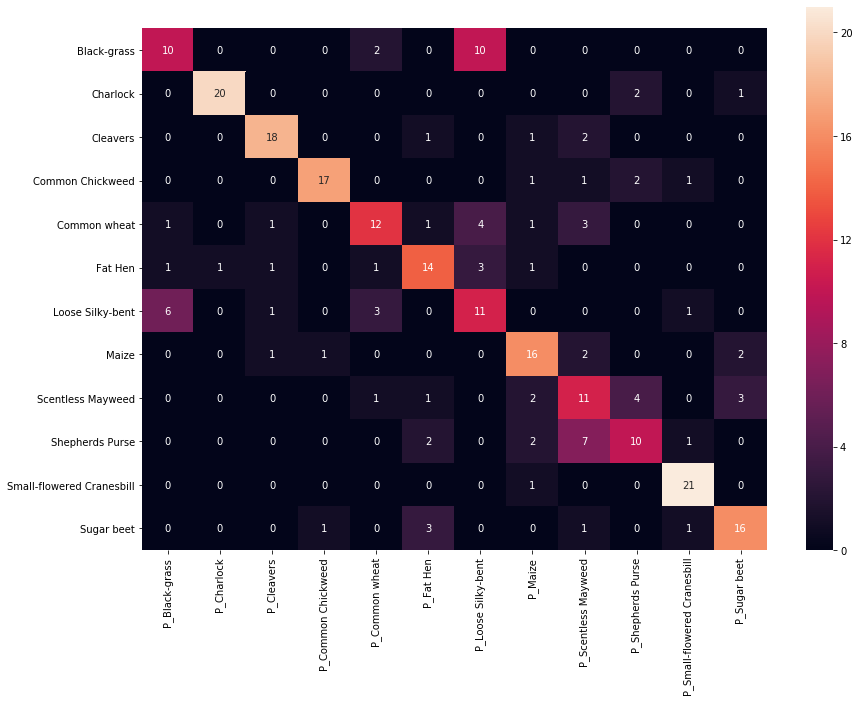

In [84]:
fig, ax  = plt.subplots(figsize=(14,10))
sns.heatmap(testData['CM'], annot=True,fmt="d")
ax.set_ylim(len(testData['CM']), -0.5)
plt.show()

In [85]:
df = testData['Data']

In [86]:
df.head()

,FileName,Class,PredictedClass
262,fef14b865.png,0,0
230,ffb54800c.png,9,8
334,9ab3b61db.png,8,11
63,1a570b7db.png,8,7
136,907817b91.png,7,11


In [98]:
df.loc[(df['Class']==0) & (df['PredictedClass']==0)]

,FileName,Class,PredictedClass
262,fef14b865.png,0,0
223,daa7d4620.png,0,0
138,8dd397cd9.png,0,0
210,cfbe062b3.png,0,0
86,53ab7a3da.png,0,0
16,0dad57e7f.png,0,0
244,ed0bc2794.png,0,0
213,d112c9c28.png,0,0
238,e7d7e6351.png,0,0
15,0d4f74f4a.png,0,0


In [99]:
df.loc[(df.Class==0) & (df.PredictedClass==0)]

,FileName,Class,PredictedClass
262,fef14b865.png,0,0
223,daa7d4620.png,0,0
138,8dd397cd9.png,0,0
210,cfbe062b3.png,0,0
86,53ab7a3da.png,0,0
16,0dad57e7f.png,0,0
244,ed0bc2794.png,0,0
213,d112c9c28.png,0,0
238,e7d7e6351.png,0,0
15,0d4f74f4a.png,0,0


In [112]:
TruePos = (df.Class==0) & (df.PredictedClass==0)
FalsePos = (df.Class!=0) & (df.PredictedClass==0)
FalseNeg = (df.Class==0) & (df.PredictedClass!=0)
df.loc[FalseNeg,["Class","PredictedClass"]]

,Class,PredictedClass
38,0,6
135,0,6
64,0,6
235,0,6
128,0,6
116,0,6
226,0,6
233,0,4
98,0,4
47,0,6
